# 5 - Convolutional Sequence to Sequence Learning

In this notebook we'll be implementing the [Convolutional Sequence to Sequence Learning](https://arxiv.org/abs/1705.03122) model. 




## Preparing the Data

First, let's import all the required modules and set the random seeds for reproducability.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [28]:
!pip install torchtext==0.6.0
!pip install spacy download en
!pip install spacy download fr

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.data.metrics import bleu_score
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np
from pathlib import Path
import random
import math
import time
import pandas as pd
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
import pandas as pd

import torchtext.data as ttd

import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
from torch.utils import data
import torch.nn as nn
import torch.optim.lr_scheduler
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import gensim 
import gensim.downloader as api
from gensim.models import Word2Vec  
#from torchnlp.word_to_vector import GloVe, FastText
import torchtext.data as ttd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer, word_tokenize, sent_tokenize, TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from nltk.stem.porter import PorterStemmer 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
#from warnings import simplefilter
#simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.datasets import fetch_20newsgroups

from torch.utils.data import TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from torch.utils.data import TensorDataset, random_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
folder=Path('/content/gdrive/My Drive/NLP/Project2')

In [31]:
df = pd.read_csv(folder / 'fra.txt',sep='\t',header=None)
df.head()
data=df[[0,1]]
data.head(10)
data.to_csv("train.csv",index=False)

In [32]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [33]:
!python -m spacy download fr
spacy_en = spacy.load('en')
spacy_fr = spacy.load('fr')

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')


Then, we load our dataset.

In [8]:
spacy_fr = spacy.load('fr')
spacy_en = spacy.load('en')

In [34]:
def tokenize_fr(text):
    """
    Tokenizes French text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

The final bit of data preparation is defining the device and then building the iterator.

In [35]:
SRC = Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

In [36]:
from torchtext.data import Field, BucketIterator,TabularDataset
train_dataset = TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,        
        fields=[('src', SRC), ('trg', TRG)])

import random
SEED=123
training_dataset, testing_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))
train_dataset, validation_dataset = training_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [37]:
print(vars(train_dataset.examples[0]))

{'src': ['i', 'spent', 'the', 'day', 'with', 'tom', '.'], 'trg': ["j'ai", 'passé', 'la', 'journée', 'avec', 'tom', '.']}


In [38]:
SRC.build_vocab(train_dataset, min_freq = 2)
TRG.build_vocab(train_dataset, min_freq = 2)

In [39]:
print(f"Unique tokens in source (fr) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (fr) vocabulary: 8578
Unique tokens in target (en) vocabulary: 14007


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, validation_dataset, testing_dataset), 
    batch_size = BATCH_SIZE, 
    sort = False,
    device = device)

## Building the Model

Next up is building the model. As before, the model is made of an encoder and decoder. The encoder *encodes* the input sentence, in the source language, into a *context vector*. The decoder *decodes* the context vector to produce the output sentence in the target language.

### Encoder

### Convolutional Blocks

### Encoder Implementation



In [43]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #create position tensor
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [0, 1, 2, 3, ..., src len - 1]
        
        #pos = [batch size, src len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = pos_embedded = [batch size, src len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, src len, emb dim]
        
        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, src len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, src len]
        
        #begin convolutional blocks...
        
        for i, conv in enumerate(self.convs):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))

            #conved = [batch size, 2 * hid dim, src len]

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale

            #conved = [batch size, hid dim, src len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        #conved = [batch size, src len, emb dim]
        
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        
        #combined = [batch size, src len, emb dim]
        
        return conved, combined

### Decoder


### Decoder Convolutional Blocks

### Decoder Impementation



In [44]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        
        #conved_emb = [batch size, trg len, emb dim]
        
        combined = (conved_emb + embedded) * self.scale
        
        #combined = [batch size, trg len, emb dim]
                
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        
        #energy = [batch size, trg len, src len]
        
        attention = F.softmax(energy, dim=2)
        
        #attention = [batch size, trg len, src len]
            
        attended_encoding = torch.matmul(attention, encoder_combined)
        
        #attended_encoding = [batch size, trg len, emd dim]
        
        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        #attended_encoding = [batch size, trg len, hid dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        
        #attended_combined = [batch size, hid dim, trg len]
        
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
        
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        #create position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, trg len, emb dim]
        
        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, trg len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, trg len]
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
                
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
        
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input)

            #conved = [batch size, 2 * hid dim, trg len]
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, trg len]
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            
            #attention = [batch size, trg len, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            
            #conved = [batch size, hid dim, trg len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
         
        #conved = [batch size, trg len, emb dim]
            
        output = self.fc_out(self.dropout(conved))
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Seq2Seq



In [45]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for 
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

## Training the Seq2Seq Model



In [46]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 41,699,255 trainable parameters


In [48]:
optimizer = optim.Adam(model.parameters())

In [49]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [50]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [51]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Again, we have a function that tells us how long each epoch takes.

In [52]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [53]:
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 4m 11s
	Train Loss: 1129448.909
	 Val. Loss: 1879296.845
Epoch: 02 | Time: 4m 9s
	Train Loss: 10290194.466
	 Val. Loss: 2669576.354
Epoch: 03 | Time: 4m 8s
	Train Loss: 14727050.117
	 Val. Loss: 3125492.067
Epoch: 04 | Time: 4m 8s
	Train Loss: 52206428.353
	 Val. Loss: 7297705.968
Epoch: 05 | Time: 4m 8s
	Train Loss: 53442556.505
	 Val. Loss: 12623082.860
Epoch: 06 | Time: 4m 8s
	Train Loss: 89285174.056
	 Val. Loss: 24627308.138
Epoch: 07 | Time: 4m 8s
	Train Loss: 88567234.880
	 Val. Loss: 29800121.073
Epoch: 08 | Time: 4m 8s
	Train Loss: 110296941.406
	 Val. Loss: 24013846.407
Epoch: 09 | Time: 4m 8s
	Train Loss: 107474456.580
	 Val. Loss: 9840800.532
Epoch: 10 | Time: 4m 8s
	Train Loss: 87948433.697
	 Val. Loss: 13646796.310


We then load the parameters which obtained the lowest validation loss and calculate the loss over the test set. 

In [54]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 1901936.373


## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- feed the source sentence into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - place the current output and the two encoder outputs into the decoder
  - get next output token prediction from decoder
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [55]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

Next, we have a function what will display how much the model pays attention to each input token during each step of the decoding.

In [56]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Then we'll finally start translating some sentences. **Note**: these sentences have been cherry picked.

First, we'll get an example from the training set:

In [57]:
example_idx = 2

src = vars(train_dataset.examples[example_idx])['src']
trg = vars(train_dataset.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['that', 'was', 'so', 'awesome', '.']
trg = ["c'était", 'tellement', 'génial', '.']


Then we pass it into our `translate_sentence` function which gives us the predicted translation tokens as well as the attention.

We can see that it doesn't give the exact same translation, however it does capture the same meaning as the original. It is actual a more literal translation as *aus holz* literally translates to *of wood*, so a *wooden playhouse* is the same thing as a *playhouse made of wood*.

In [58]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['est', 'est', 'est', 'est', 'est', 'est', 'lui', 'est', 'est', 'à', 'est', 'est', 'est', '<eos>']


We can view the attention of the model, making sure it gives sensibile looking results.

We can see it correctly pays attention to *aus* when translation both *made* and *of*. 

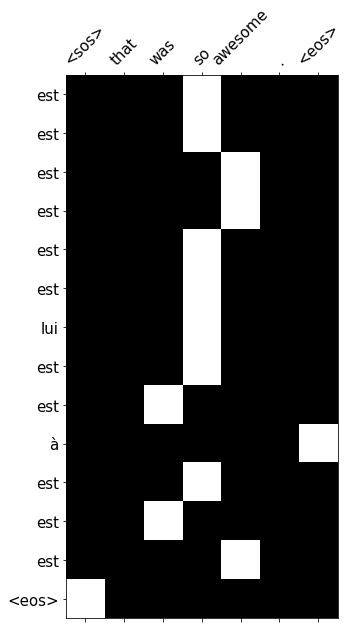

In [59]:
display_attention(src, translation, attention)

Let's see how well it translates an example that is not in the training set.

In [60]:
example_idx = 2

src = vars(validation_dataset.examples[example_idx])['src']
trg = vars(validation_dataset.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['tom', 'said', 'he', 'found', 'something', 'under', 'the', 'couch', '.']
trg = ['tom', 'a', 'dit', "qu'il", 'avait', 'trouvé', 'quelque', 'chose', 'sous', 'le', 'canapé', '.']


The model manages to do a decent job at this one, except for changing *wearing* to *in*.

In [61]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['est', 'est', 'est', 'est', 'est', 'est', 'à', 'est', 'à', 'à', 'chez', 'à', 'est', 'un', 'à', 'est', 'est', '<eos>']


Again, we can see the attention is applied to sensible words - *junge* for *boy*, etc.

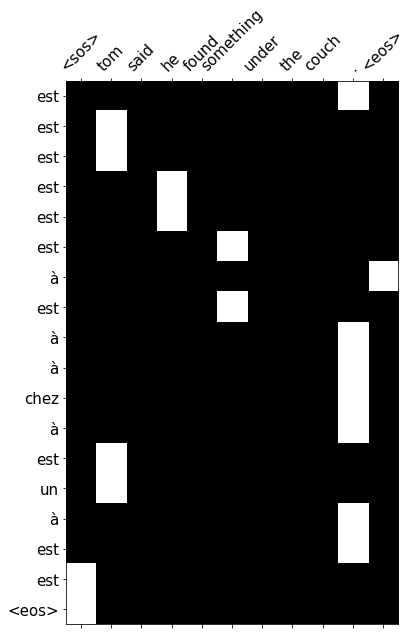

In [62]:
display_attention(src, translation, attention)

Finally, let's check an example from the test set.

In [63]:
example_idx = 9

src = vars(testing_dataset.examples[example_idx])['src']
trg = vars(testing_dataset.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ["don'", 't', 'tell', 'my', 'girlfriend', '.']
trg = ['ne', 'dis', 'rien', 'à', 'ma', 'nana', '!']


In [64]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['est', 'est', 'à', 'à', 'à', '<eos>']


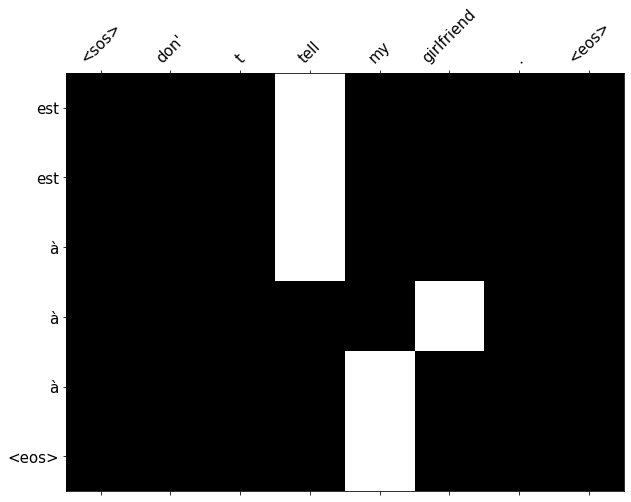

In [65]:
display_attention(src, translation, attention)

## BLEU

Finally, we calculate the BLEU score for the model.

In [66]:

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(testing_dataset, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')